In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

import matplotlib.pyplot as plt
from PIL import Image
import random, os
import numpy as np
import shap

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Load and visualize the data, and create dataloaders

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#train and test data directory
data_dir = "/kaggle/input/pcos-detection-using-ultrasound-images/data/train"
test_data_dir = "/kaggle/input/pcos-detection-using-ultrasound-images/data/test"

In [7]:
### Redefine the 'ImageFolder' class so it won't load the corrupted files

class ImageFolderEX(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        try:
            sample = self.loader(path)
        except:
            return None
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return sample, target

In [8]:
transform = transforms.Compose([transforms.Resize((256,256)),
                                transforms.ToTensor()])

#load the train and test data
dataset = ImageFolderEX(data_dir, transform = transform)
test_ds = ImageFolderEX(test_data_dir, transform = transform)

print('dataset samples:', len(dataset))
print('test samples:', len(test_ds))
print("Classes are:", dataset.classes)

img, label = dataset[0]
print(f'Example: first sample size: {img.shape}, and label: {label}')

dataset samples: 1924
test samples: 1932
Classes are: ['infected', 'notinfected']
Example: first sample size: torch.Size([3, 256, 256]), and label: 0


In [9]:
batch_size = 128
val_size = 400
train_size = len(dataset) - val_size

train_data, val_data = random_split(dataset, [train_size, val_size])

print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

Length of Train Data : 1524
Length of Validation Data : 400


In [11]:
#load the train and validation into batches
def collate_fn(batch):
    batch = list(filter(lambda x: x is not None, batch))
    return torch.utils.data.dataloader.default_collate(batch)

train_dl = DataLoader(train_data, batch_size, shuffle = True, collate_fn=collate_fn, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, collate_fn=collate_fn, num_workers = 4, pin_memory = True)
test_dl = DataLoader(test_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)

torch.Size([128, 3, 256, 256]) torch.Size([128])


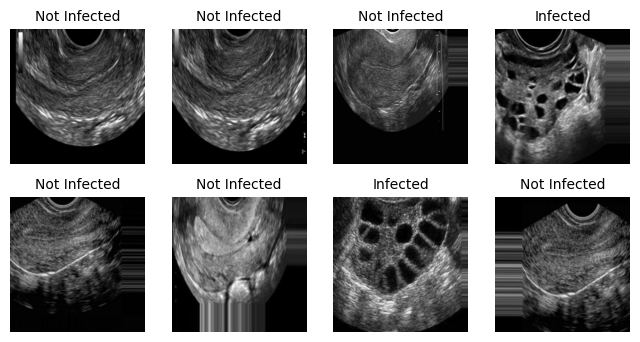

In [12]:
# Get one batch from dataset
images, labels = next(iter(train_dl))
print(images.shape , labels.shape)

plt.figure(figsize=(8,4))

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(images[i,0], cmap=plt.cm.gray)
    if labels[i]==0:
        plt.title('Infected', fontsize=10)
    else:
        plt.title('Not Infected', fontsize=10)
    plt.axis("off")

## Define the CNN model
I used the model from here: <https://medium.com/thecyphy/train-cnn-model-with-pytorch-21dafb918f48>, 
and the same architecture as Model2 in: <https://www.kaggle.com/code/aykorde/fightos-cnn-models#Model-2>

In [13]:
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        images = images.to(device)
        labels = labels.to(device)
        
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [15]:
class Classifier(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(3, 12, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(3,3),
            
            nn.Conv2d(12, 15, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(3,3),
        
            nn.Conv2d(15, 10, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(3,3),
            
            nn.Flatten(),
            nn.Linear(810, 2),
        )
    
    def forward(self, xb):
        return self.network(xb)

In [16]:
model = Classifier().to(device)

for name, params in model.named_parameters():
    print('layer name: {}, \t params shape: {}'.format(name, params.shape))

layer name: network.0.weight, 	 params shape: torch.Size([12, 3, 3, 3])
layer name: network.0.bias, 	 params shape: torch.Size([12])
layer name: network.3.weight, 	 params shape: torch.Size([15, 12, 3, 3])
layer name: network.3.bias, 	 params shape: torch.Size([15])
layer name: network.6.weight, 	 params shape: torch.Size([10, 15, 3, 3])
layer name: network.6.bias, 	 params shape: torch.Size([10])
layer name: network.10.weight, 	 params shape: torch.Size([2, 810])
layer name: network.10.bias, 	 params shape: torch.Size([2])


In [17]:
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.001

#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.6752, val_loss: 0.6498, val_acc: 0.6053
Epoch [1], train_loss: 0.6195, val_loss: 0.5166, val_acc: 0.8164
Epoch [2], train_loss: 0.4464, val_loss: 0.3049, val_acc: 0.8691
Epoch [3], train_loss: 0.3329, val_loss: 0.2474, val_acc: 0.8819
Epoch [4], train_loss: 0.2859, val_loss: 0.2091, val_acc: 0.9095
Epoch [5], train_loss: 0.2362, val_loss: 0.1743, val_acc: 0.9444
Epoch [6], train_loss: 0.1929, val_loss: 0.1425, val_acc: 0.9581
Epoch [7], train_loss: 0.1387, val_loss: 0.0944, val_acc: 0.9681
Epoch [8], train_loss: 0.0949, val_loss: 0.0687, val_acc: 0.9822
Epoch [9], train_loss: 0.0623, val_loss: 0.0541, val_acc: 0.9852
Epoch [10], train_loss: 0.0464, val_loss: 0.0410, val_acc: 0.9876
Epoch [11], train_loss: 0.0304, val_loss: 0.0243, val_acc: 0.9931
Epoch [12], train_loss: 0.0198, val_loss: 0.0202, val_acc: 0.9931
Epoch [13], train_loss: 0.0163, val_loss: 0.0138, val_acc: 1.0000
Epoch [14], train_loss: 0.0121, val_loss: 0.0122, val_acc: 1.0000
Epoch [15], train_lo

In [18]:
#save the model
torch.save(model.state_dict(), 'PCOS_detection_{}_epochs_val_acc_{}.pth'.format(num_epochs, history[-1]['val_acc']))

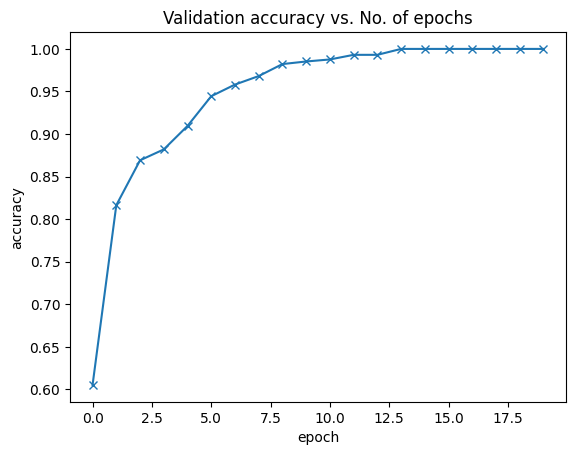

In [19]:
def plot_accuracies(history):
    """ Plot the history of accuracies"""
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Validation accuracy vs. No. of epochs');

plot_accuracies(history)

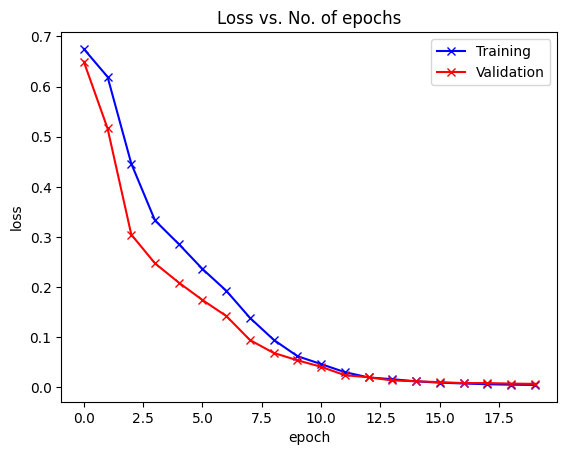

In [20]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_losses(history)

## Evaluate on Test Dataset

In [21]:
result = evaluate(model, test_dl)
result

{'val_loss': 0.0046102069318294525, 'val_acc': 1.0}

In [22]:
def predict_img_class(img,model):
    """ Predict the class of image and Return Predicted Class"""
    img = img.unsqueeze(0).to(device)
    prediction =  model(img)
    _, preds = torch.max(prediction, dim = 1)
    return dataset.classes[preds[0].item()]

Predicted Class: infected


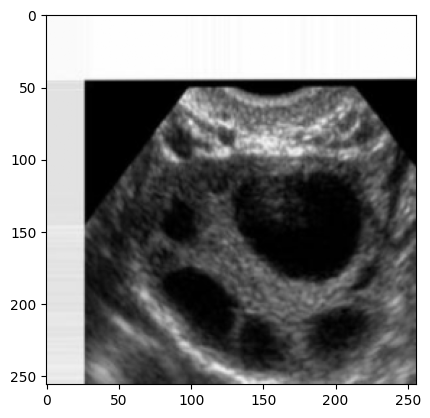

In [23]:
test_img = random.choice(os.listdir('/kaggle/input/pcos-detection-using-ultrasound-images/data/test/infected'))
img = Image.open(f'/kaggle/input/pcos-detection-using-ultrasound-images/data/test/infected/{test_img}')
img = transform(img)
plt.imshow(img.permute(1,2,0))

pred = predict_img_class(img,model)
print(f"Predicted Class: {pred}")

## Explain the model using SHAP Explainer

In [24]:
# Use CPU for SHAP explainer
shap_device = torch.device('cpu')
model = model.to(shap_device)

In [25]:
#Load a batch from train data for background
background, labels = next(iter(train_dl))
background = background.to(shap_device)

#Load a batch from test data
test_images, test_labels = next(iter(test_dl))

print('background images:', background.shape)
print('background labels:', labels.shape)
print('test images:', test_images.shape)

background images: torch.Size([128, 3, 256, 256])
background labels: torch.Size([128])
test images: torch.Size([8, 3, 256, 256])


In [26]:
#Create the SHAP explainer and get shap values
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(test_images)

print('Shap values:', len(shap_values), shap_values[0].shape)

unrecognized nn.Module: Flatten


Shap values: 2 (8, 3, 256, 256)


In [27]:
# Convert to numpy and reshape for plotting
shap_numpy = list(np.array(shap_values).transpose(0,1,3,4,2))
test_numpy = np.array(test_images).transpose(0,2,3,1)

print('Shap values, numpy:', len(shap_numpy), shap_numpy[0].shape)
print('test images, numpy:', test_numpy.shape)

Shap values, numpy: 2 (8, 256, 256, 3)
test images, numpy: (8, 256, 256, 3)


In [28]:
test_list_labels = list(np.array(test_labels))
GT_labels = [dataset.classes[test_list_labels[i].item()] for i in range(len(test_list_labels))]
print(GT_labels)

['infected', 'infected', 'notinfected', 'infected', 'notinfected', 'notinfected', 'notinfected', 'infected']


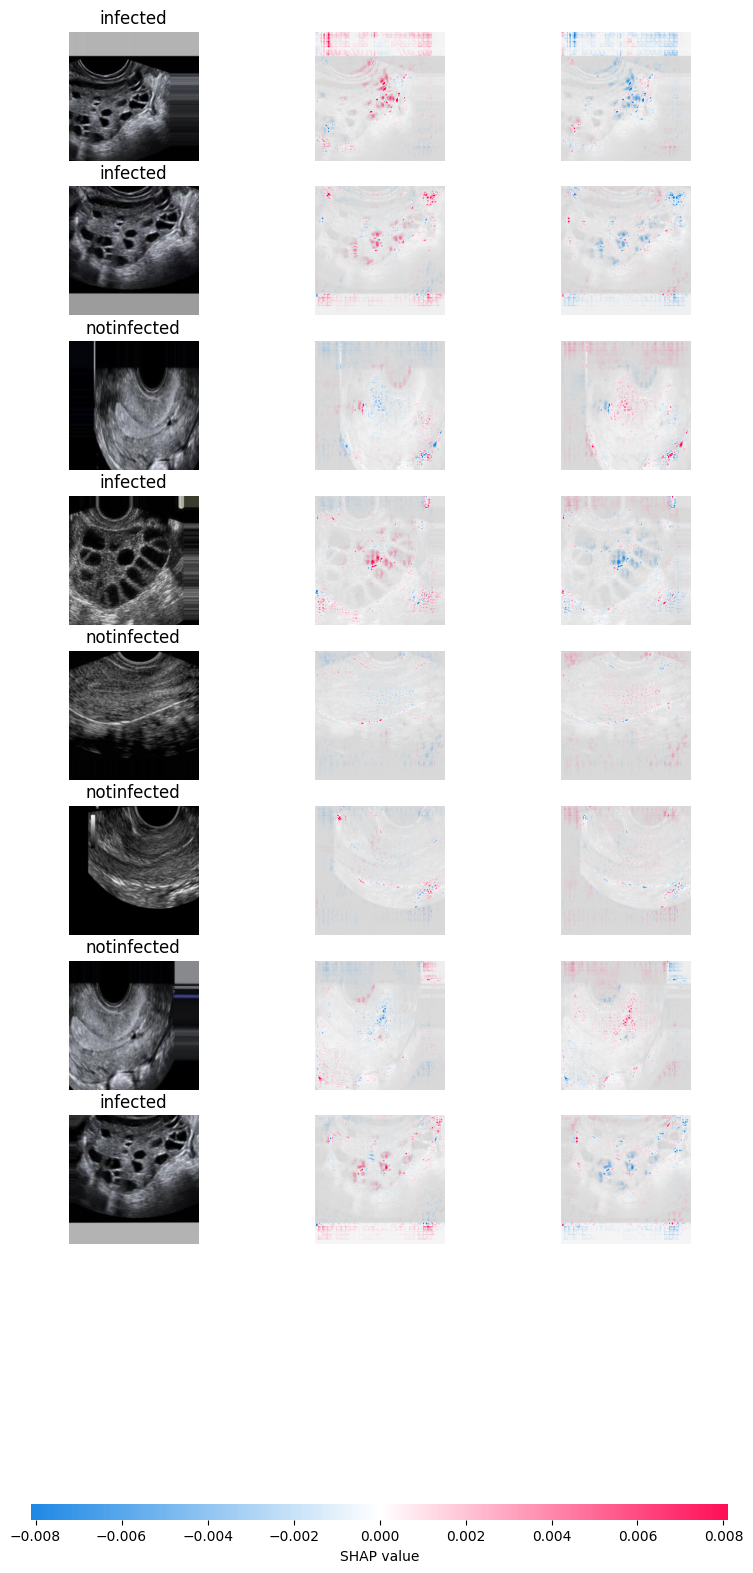

In [29]:
# shap.image_plot(shap_numpy, test_numpy, labels=dataset.classes, true_labels=GT_labels)
shap.image_plot(shap_numpy, test_numpy, true_labels=GT_labels)